In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


questions:


1) How is it easiest to break into the field?

2) What are the most important Frameworks, Libraries, and Tools data scientists use?

3) Are data scientists happier with their job than others?

4) do data scientists who contribute to open source have a higher salary than others? 

In [5]:
cd gdrive/My\ Drive/data_science

/content/gdrive/My Drive/data_science


In [6]:
import pandas as pd
import re as _re
import seaborn as _sns
import numpy as _np
from scipy.stats import levene
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

df = pd.read_csv('survey_results_public.csv')
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,Financial performance or funding status of the...,"Something else changed (education, award, medi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,THB,Thai baht,23000.0,Monthly,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never

In [0]:
# create a flag for being a data scientist
df['is_data_scientist'] = df["DevType"].str.contains("Data scientist or machine learning specialist")

# 1) How is it easiest to break into the field?

## Method:




In [0]:
# Take a look at subset of data consisting of individuals adding `Data scientist or machine learning specialist` as `DevType` 

ds_df = df.query("is_data_scientist == True").copy()

In [9]:
print("How many individuals say they are `Data scientist or machine learning specialist`?\n")

print(
    f"Out of {len(df)} respondents, {len(ds_df)} say they are `Data scientist "
    f"or machine learning specialist`.\n"
    f"This is a share of {len(ds_df)/len(df):.1%}"
    )

How many individuals say they are `Data scientist or machine learning specialist`?

Out of 88883 respondents, 6460 say they are `Data scientist or machine learning specialist`.
This is a share of 7.3%


In [0]:
def get_shares(df, col, delimiter=';'):
  list_col = 'list_' + col
  df[list_col] = df[col].str.split(delimiter)
  
  sample_cnt = len(df)
  tmp_df = df[list_col].apply(pd.Series).stack()
  share_df = tmp_df.value_counts().to_frame().rename(
      columns={0: 'cnt'}
  )
  share_df["share"] = share_df["cnt"] / sample_cnt
  share_df["metric"] = col
  share_df = share_df.reset_index().rename(columns={'index': 'description'})
  return share_df

In [11]:
other_dev_types = get_shares(df=ds_df, col="DevType", delimiter=';').iloc[1:]
other_dev_types.head()

,description,cnt,share,metric
1,"Developer, back-end",3075,0.476006,DevType
2,"Developer, full-stack",2445,0.378483,DevType
3,Data or business analyst,2079,0.321827,DevType
4,Academic researcher,1874,0.290093,DevType
5,"Engineer, data",1872,0.289783,DevType


In [12]:
other_dev_types.head()

,description,cnt,share,metric
1,"Developer, back-end",3075,0.476006,DevType
2,"Developer, full-stack",2445,0.378483,DevType
3,Data or business analyst,2079,0.321827,DevType
4,Academic researcher,1874,0.290093,DevType
5,"Engineer, data",1872,0.289783,DevType


In [0]:
def plot_shares(x, y, color):
  plot_args = {
    'x': x,
    'y': y,
    'color': color
  }
  ax = _sns.barplot(**plot_args)
  ax.set_xticklabels(labels=plot_args['x'], rotation=90);
  vals = ax.get_yticks()
  ax.set_yticklabels(['{:,.0%}'.format(y_val) for y_val in vals]);

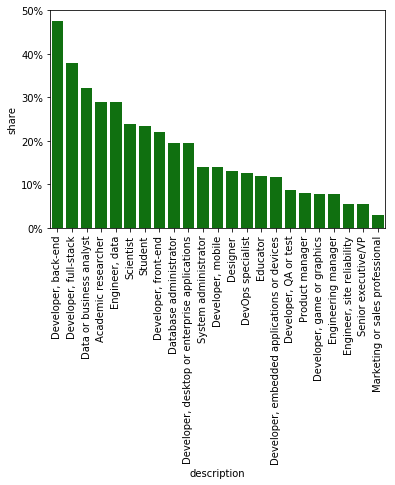

In [14]:
plot_shares(x=other_dev_types['description'], y=other_dev_types["share"], color='g')

Most developers stating that they are data scientists also say that they are back-end Developers. Second most say they are full-stack developers, and on position 3 Data or business analysts claim that they are Data Scientists.
Considering the high share of more then 7% of developers stating they are data scientists, it is questionable whether all respondents really spend the majority of their time with data scientist tasks. 
Nevertheless it gives some intuition that back-end skills and full-stack skills are very helpful to be effective as Data Scientist Practitioner. Data and business Analysts might on the other side be able to pick up deeper coding skills or work in cross-functional teems where they get help to put data science models into production.

# What are the most important Frameworks, Libraries, and Tools data scientists use?

Let's dive deeper into which frameworks, libraries, and tools Data Scientists use accordingly to the Stackoverflow developers survey. In the following I will show the 10 most used languages Data Scientists worked with, the databases they used, and wich web-frameworks they are familiar with and which other Technologies they use.

In [0]:
metrics = [
  "LanguageWorkedWith",
  "DatabaseWorkedWith",
  "PlatformWorkedWith",
  "WebFrameWorkedWith",
  "MiscTechWorkedWith",
]

In [0]:
mydf = pd.DataFrame()

for __, metric in enumerate(metrics):
  mydf = mydf.append(get_shares(df=ds_df, col=metric, delimiter=';'), ignore_index=True)

In [0]:
%timeit
mydf = pd.DataFrame()

for __, metric in enumerate(metrics):
  mydf = mydf.append(get_shares(df=ds_df, col=metric, delimiter=';'));

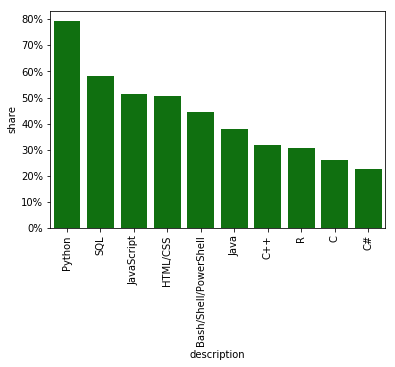

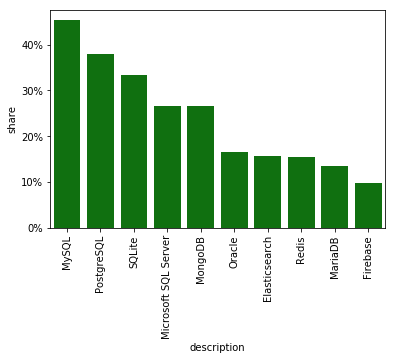

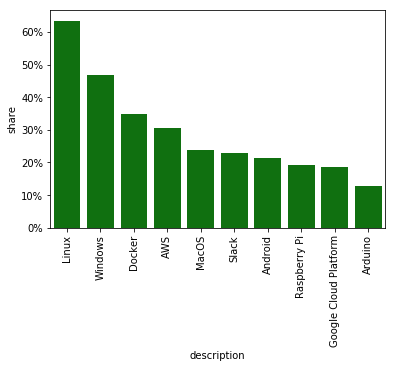

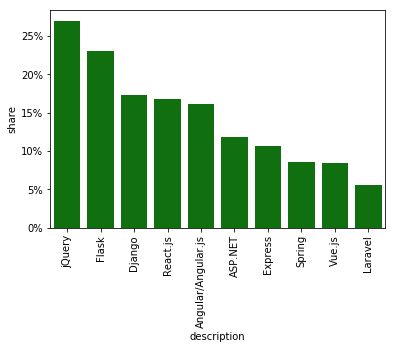

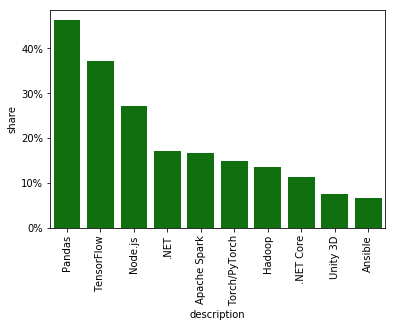

In [18]:
for metric in metrics:
  plot_shares(x=mydf.query("metric == @metric")["description"][:10], y=mydf.query("metric == @metric")["share"], color='g')
  plt.show()

# Are data scientists happier with their job than others?

The last question to answer in this post is no matter how it is easiest to break into the field and no matter what tools they use - Is it acutally even worth the effort and are Data Scientists happier with their job than other developers?

In [19]:
# check encoding of `Job Satisfaction`
ds_df['JobSat'].unique()

array(['Slightly satisfied', 'Slightly dissatisfied', nan,
       'Very satisfied', 'Neither satisfied nor dissatisfied',
       'Very dissatisfied'], dtype=object)

In [0]:
cat survey_results_schema.csv | grep satisfaction

In [0]:
# encode strings to numbers
job_satisfaction_mapping = {
    'Very dissatisfied': 0,
    'Slightly dissatisfied': 1,
    'Neither satisfied nor dissatisfied': 2,    
    'Slightly satisfied': 3, 
    'Very satisfied': 4,
 }

In [0]:
# create column with mapping of strings to integers
df['JobSatNumeric'] = df['JobSat'].map(job_satisfaction_mapping, na_action='ignore')

In [0]:
# t_test_stats = df.groupby('is_data_scientist')['JobSatNumeric'].agg(['mean', 'std'])
# t_test_stats

In [24]:
# split data into reference and test set 
ref_w_na = df.query('is_data_scientist == False')['JobSatNumeric']
test_w_na = df.query('is_data_scientist == True')['JobSatNumeric']

# remove `NaN`s
ref = ref_w_na.dropna()
test = test_w_na.dropna()

descriptive_stats = df.groupby('is_data_scientist')['JobSatNumeric'].agg(['mean', 'std'])

ref_mean = descriptive_stats.loc[False]['mean']
ref_std = descriptive_stats.loc[False]['std']
test_mean = descriptive_stats.loc[True]['mean']
test_std = descriptive_stats.loc[False]['std']

print("REFERENCE")
print("=========\n")
print(f"`NaN` values removed from analysis: {len(ref_w_na) - len(ref)}")

print(f"Number of observations: {len(ref)}")
print(f"Mean: {ref_mean:.2f}")
print(f"Standard deviation: {ref_std:.2f}")
print("\n")

print("TEST")
print("====\n")
print(f"`NaN` values removed from analysis: {len(test_w_na) - len(test)}")
print(f"Number of observations: {len(test)}")
print(f"Mean: {test_mean:.2f}")
print(f"Standard deviation: {test_std:.2f}")

REFERENCE

`NaN` values removed from analysis: 10546
Number of observations: 64329
Mean: 2.68
Standard deviation: 1.25


TEST
====

`NaN` values removed from analysis: 1083
Number of observations: 5377
Mean: 2.77
Standard deviation: 1.25


In [25]:
# ! pip install seaborn==0.9.0
import seaborn as sns
from scipy.stats import norm
# sns.distplot(ref, kde_kws={'bw':1});

# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()

sns.distplot(ref, kde=False, ax=ax1, f="ref")
# sns.distplot(ref, hist=False, ax=ax2, kde_kws={'bw':1})
# plt.legend(prop={'size': 12})

TypeError: ignored

In [51]:
np.arange(test.min() - 0.5, test.max() + 0.5)

array([-0.5,  0.5,  1.5,  2.5,  3.5])

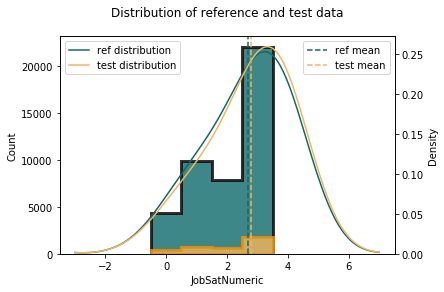

In [66]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

bins = np.arange(test.min() - 0.5, test.max() + 0.5)

sns.distplot(
    ref, 
    color='#0d696b', 
    hist_kws={
        "histtype": "stepfilled", 
        "linewidth": 3, 
        "alpha": .8, 
        "color": "#0d696b",
        "edgecolor": "#0d0000",
    }, 
    kde=False, 
    ax=ax1, 
    bins=bins
)

sns.distplot(
    ref, 
    color='#0d696b', 
    hist=False, 
    ax=ax2, 
    kde_kws={'bw':1}, label="ref distribution"
)
ax1.axvline(ref_mean, color='#0d696b', linestyle='--', label="ref mean")

sns.distplot(
    test, 
    color='#f4b65c', 
    hist_kws={
        "histtype": "stepfilled", 
        "linewidth": 3, 
        "alpha": .8, 
        "color": "#f4b65c",
        "edgecolor": "#f49000",
    }, 
    kde=False, 
    ax=ax1, 
    bins=bins
)
sns.distplot(
    test, 
    color='#f4b65c', 
    hist=False, 
    ax=ax2, 
    kde_kws={'bw':1}, 
    label="test distribution"
)
ax1.axvline(test_mean, color='#f4b65c', linestyle='--', label="test mean")
ax1.legend();
ax1.set_title("Distribution of reference and test data", pad=20);
ax1.set_ylabel("Count");
ax1.set_ylabel("Count");
ax2.set_ylabel("Density");
plt.rcParams["patch.force_edgecolor"] = True

In [139]:
test

count    5377.000000
mean        2.769388
std         1.244634
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: JobSatNumeric, dtype: float64

In [106]:

# The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
levene_statistic, levene_pvalue = levene(ref, test)
# test not significant, therefor equal variances can be assumed
print(f"levene statistic: {levene_statistic}, levene p-value: {levene_pvalue}")

statistic, two_sided_pvalue = ttest_ind(a=ref, b=test, axis=0, equal_var=True)
# half the p-value as t-test is performing a two-sided test and we have a one-sided hypothesis
one_sided_pvalue = two_sided_pvalue / 2

print(f"The test is significant on a confidence level of 95%, the p-value is: {one_sided_pvalue:.7f}")

levene statistic: 1.0668981200409065, levene p-value: 0.30165072324487513
The test is significant on a confidence level of 95%, the p-value is: 0.0000002


#  do data scientist have more healthy habits than other programmers?

In [177]:
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase,is_data_scientist,JobSatNumeric
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult,NaN,NaN
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,Financial performance or funding status of the...,"Something else changed (education, award, medi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult,False,NaN
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,THB,Thai baht,23000.0,Monthly,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never,Home,Average,N

In [199]:
cat survey_results_schema.csv | grep Source

OpenSourcer,How often do you contribute to open source?
OpenSource,How do you feel about the quality of open source software (OSS)?


In [0]:
def calculate_t_test(ref, test, two_sided=False):
  ref = ref.dropna()
  test = test.dropna()

  # The Levene test tests the null hypothesis that all input samples are 
  # from populations with equal variances.
  levene_statistic, levene_pvalue = levene(ref, test)
  # test not significant, therefor equal variances can be assumed
  print(f"levene statistic: {levene_statistic}, levene p-value: {levene_pvalue}")
  if levene_pvalue >= 0.05:
    statistic, two_sided_pvalue = ttest_ind(a=ref, b=test, axis=0, equal_var=True)
    # half the p-value as t-test is performing a two-sided test and we have a one-sided hypothesis
    if two_sided == True:
      one_sided_pvalue = two_sided_pvalue / 2
      if one_sided_pvalue > 0.05:
        evaluation = ' not'
      else:
        print(f"The test is {evaluation} significant on a confidence level of 95%, the p-value is: {one_sided_pvalue:.7f}")
    else:
      if two_sided_pvalue > 0.05:
        evaluation = ' not'

      print(f"The test is {evaluation} significant on a confidence level of 95%, the p-value is: {two_sided_pvalue:.7f}")
  else:
    print("Consider calculating Welch t-test")


In [219]:
calculate_t_test(
    ref=df.query('is_data_scientist == False')['ConvertedComp'], 
    test=df.query('is_data_scientist == True')['ConvertedComp']
)

levene statistic: 10.86134287223919, levene p-value: 0.0009825448799474236
Consider calculating Welch t-test


In [200]:
ds_df["OpenSourcer"].

array(['Never', 'Once a month or more often',
       'Less than once a month but more than once per year',
       'Less than once per year'], dtype=object)

In [0]:
open_source_mapping = {
    'Never': False, 
    'Less than once per year': np.nan,
    'Less than once a month but more than once per year': np.nan,    
    'Once a month or more often': True,
}

In [0]:
ds_df["is_regular_open_sourcer"] = ds_df["OpenSourcer"].map(open_source_mapping)

In [227]:
ds_df["is_regular_open_sourcer"].head()

5     False
9      True
11    False
32      NaN
61      NaN
Name: is_regular_open_sourcer, dtype: object

In [228]:
calculate_t_test(
    ref=ds_df.query('is_regular_open_sourcer == False')['ConvertedComp'], 
    test=ds_df.query('is_regular_open_sourcer == True')['ConvertedComp']
)

levene statistic: 0.6159679942613298, levene p-value: 0.4326514275269554
The test is  not significant on a confidence level of 95%, the p-value is: 0.4417454


In [231]:
ds_df.groupby(["is_regular_open_sourcer"])["ConvertedComp"].mean()

is_regular_open_sourcer
False    142364.315442
True     154889.438312
Name: ConvertedComp, dtype: float64